<a href="https://colab.research.google.com/github/takumi-maker/bert/blob/main/DMD_prototype_check2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
from scipy.linalg import svd
import warnings

In [ ]:
a=np.array([[1,2,3]])
b=np.array([[2,3,4]])
c =b-a
print(c)

[[1 1 1]]


In [ ]:
df_1 = pd.read_csv("最長複利データ20407.csv")
df_1 = df_1.drop(df_1.columns[0], axis=1)
columns_len = len(df_1.columns)
length = len(df_1)
df_1

,GJGC7,GJGC20,GJGC40
0,-0.051,0.595,0.813
1,-0.035,0.609,0.834
2,-0.035,0.589,0.809
3,-0.040,0.599,0.817
4,-0.045,0.613,0.834
...,...,...,...
952,-0.099,0.385,0.648
953,-0.095,0.395,0.657
954,-0.094,0.395,0.661
955,-0.094,0.400,0.670


In [ ]:
df_1 = pd.read_csv("最長複利データ20407.csv")
df_1 = df_1.drop(df_1.columns[0], axis=1)
columns_len = len(df_1.columns)
length = len(df_1)
df_1
y_df = df_1
y_df = y_df.drop('GJGC20',axis=1)
#y_df = y_df.drop('GJGC40',axis=1)
y_df

,GJGC7,GJGC40
0,-0.051,0.813
1,-0.035,0.834
2,-0.035,0.809
3,-0.040,0.817
4,-0.045,0.834
...,...,...
952,-0.099,0.648
953,-0.095,0.657
954,-0.094,0.661
955,-0.094,0.670


<Axes: >

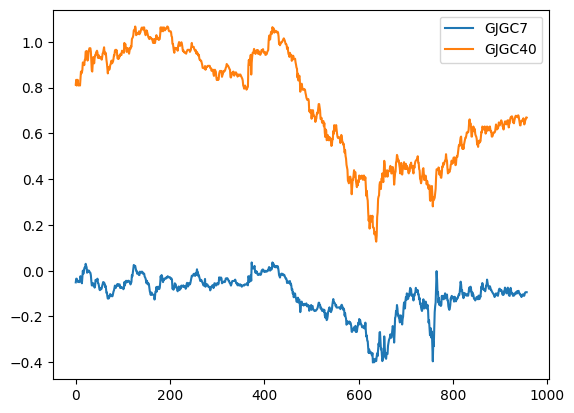

In [ ]:
y_df.plot()

In [ ]:


class DynamicModeDecomposition:
    def __init__(self, rank=None, svd_rank=None,T=None):
        """
        動的モード分解（DMD）クラス
        論文 "Dynamic mode decomposition of numerical and experimental data" に基づく実装

        Parameters:
        rank: DMDで使用するランク（Noneの場合は自動決定）
        svd_rank: SVDで使用するランク（Noneの場合は自動決定）
        """
        self.rank = rank
        self.svd_rank = svd_rank
        self.modes = None
        self.eigenvalues = None
        self.amplitudes = None
        self.Phi = None  # DMDモード
        self.omega = None  # 連続時間固有値
        self.b = None  # 初期振幅
        self.A_tilde = None  # 低次元線形演算子
        self.T = T

    def fit(self, X, dt=1.0):
        """
        DMDアルゴリズムを実行

        Parameters:
        X: データ行列 (n_features x n_timesteps)
        dt: 時間刻み
        """
        # Step 1: データをX1とX2に分割
        X1 = X[:, :-1]  # x_1, x_2, ..., x_{m-1}
        X2 = X[:, 1:]   # x_2, x_3, ..., x_m

        # Step 2: X1のSVD分解
        U, s, Vt = svd(X1, full_matrices=False)

        # Step 3: ランクの決定とtruncation
        if self.svd_rank is None:
            # 特異値の閾値による自動ランク決定
            tolerance = 1e-10
            self.svd_rank = np.sum(s > tolerance)

        r = min(self.svd_rank, len(s))
        U_r = U[:, :r]
        s_r = s[:r]
        V_r = Vt[:r, :].T

        # Step 4: 低次元線形演算子A_tildeの計算
        self.A_tilde = U_r.T @ X2 @ V_r @ np.diag(1/s_r)
        #self.A_tilde = U_r.T @ X2 @ V_r @ np.linalg.pinv(s_r)

        # Step 5: A_tildeの固有値分解
        eigenvals, W = np.linalg.eig(self.A_tilde)

        # Step 6: DMDモードの計算
        self.Phi = X2 @ V_r @ np.diag(1/s_r) @ W
        #self.Phi = X2 @ V_r @ np.linalg.pinv(s_r) @ W

        # 離散時間固有値
        self.eigenvalues = eigenvals

        # 連続時間固有値（論文の式に基づく）
        #self.omega = np.log(eigenvals) / dt
        self.omega = eigenvals #dt=1の場合 expがpredictのところで入れていないためlog入れていない

        # Step 7: 初期振幅の計算
        self.b = np.linalg.pinv(self.Phi) @ X[:, 0]

        # 使用するモード数の決定
        if self.rank is None:
            self.rank = r
        else:
            self.rank = min(self.rank, r)

        return self

    def predict(self, t_eval, x0=None):
        """
        指定された時刻での状態を予測

        Parameters:
        t_eval: 評価時刻
        x0: 初期条件（Noneの場合は学習データの初期条件を使用）

        Returns:
        X_pred: 予測された状態 (n_features )
        """
        if self.Phi is None:
            raise ValueError("まずfit()を実行してください")

        if x0 is not None:
            # 新しい初期条件での振幅計算
            b = np.linalg.pinv(self.Phi) @ x0
        else:
            b = self.b
        t_ = self.T + t_eval

        # 時間発展の計算
        # x(t) = Φ * diag(b) * exp(ω*t)

        time_evolution = np.array(self.omega[:self.rank, np.newaxis] **t_)

        # 予測
        X_pred = self.Phi[:, :self.rank] @ (b[:self.rank, np.newaxis] * time_evolution)

        return X_pred

    def compute_dmd_solution(self, t_eval, mode_indices=None):
        """
        特定のモードのみを使用したDMD解を計算

        Parameters:
        t_eval: 評価時刻
        mode_indices: 使用するモードのインデックス（Noneの場合は全モード）
        """
        if mode_indices is None:
            mode_indices = range(self.rank)

        time_evolution = np.exp(np.outer(self.omega[mode_indices], t_eval))
        X_dmd = self.Phi[:, mode_indices] @ (self.b[mode_indices, np.newaxis] * time_evolution)

        return X_dmd

In [ ]:
#15～40用
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api
import matplotlib.pyplot as plt
from sklearn import preprocessing
import cvxpy as cp

magic_num = 180
estimate_num = 150
predict_time = 1

df_array = y_df.to_numpy()


for i in range(1,8):
  total_num = 100*i
  print(total_num)

  total_list = []
  y_list = []
  current_list = []
  result_list = []
  predict_flag2 = 0
  for j in range(magic_num-1,len(df_array)):
    X_return_list = []
    for k in range(1,magic_num):
      X_return_list.append(df_array[j-k])
    y_return = (df_array[j]-df_array[j-1])*1
    current_list.append(df_array[j-1])
    y_list.append(y_return)
    X_list2 = list(reversed(X_return_list))
    total_list.append(X_list2)

  total_list = np.array(total_list)
  y_list = np.array(y_list)
  current_list = np.array(current_list)
  #print(total_list)
  #print(total_list.shape)
  #print(y_list.shape)
  for j in range(len(total_list)):
    if j <= len(total_list)-1-total_num:
      continue
    #print(j+magic_num-1)
    X_array = np.array(total_list[j])
    y_array = y_list[j]
    current_X = np.array(current_list[j])
    #print(X_array.shape)
    #print(y_array.shape)
    #print("#")

    #この後Xを転置してDMDに突っ込む
    X_DMD = X_array.T
    dmd = DynamicModeDecomposition(rank=15, svd_rank=1,T=magic_num)

    dmd.fit(X_DMD)
    X_pred = dmd.predict(predict_time)
    #print(X_pred.real)

    y_pred = X_pred[1,0].real
    #print(y_pred
    current_y = current_X[1]
    retrun_ = y_array[1]
    #print(current_y)

    if y_pred - current_y >= 0.0000:
      predict_flag = -1
    elif y_pred - current_y <-0.0000:
      predict_flag = 1
    else:
      predict_flag = predict_flag2

    if predict_flag*predict_flag2 >=0:
      result_r = retrun_*predict_flag
      result_list.append(result_r)
      predict_flag2 = predict_flag
    else:
      result_r = retrun_*predict_flag-0.01
      result_list.append(result_r)
      predict_flag2 = predict_flag
      #print("change_point:",j)

  R_sum = sum(result_list)
  SR = np.mean(np.array(result_list))/np.std(np.array(result_list))
  print("SharpRatio:",SR)
  print(R_sum)


100
SharpRatio: 0.10211923177796957
0.10999999999999999
200
SharpRatio: 0.12609787957834095
0.36500000000000005
300
SharpRatio: 0.029284242192588655
0.14200000000000018
400
SharpRatio: 0.06555002247661598
0.4890000000000001
500
SharpRatio: 0.056425622773246656
0.5200000000000002
600
SharpRatio: 0.0631652940726755
0.6930000000000006
700
SharpRatio: 0.04576674811244655
0.5530000000000003


In [ ]:
#2～10用先物が一番儲かる
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api
import matplotlib.pyplot as plt
from sklearn import preprocessing
import cvxpy as cp

magic_num = 150
estimate_num = 150
predict_time = 10

df_array = y_df.to_numpy()


for i in range(1,8):
  total_num = 100*i
  print(total_num)

  total_list = []
  y_list = []
  current_list = []
  result_list = []
  predict_flag2 = 0
  for j in range(magic_num-1,len(df_array)):
    X_return_list = []
    for k in range(1,magic_num):
      X_return_list.append(df_array[j-k])
    y_return = (df_array[j]-df_array[j-1])*1
    current_list.append(df_array[j-1])
    y_list.append(y_return)
    X_list2 = list(reversed(X_return_list))
    total_list.append(X_list2)

  total_list = np.array(total_list)
  y_list = np.array(y_list)
  current_list = np.array(current_list)
  #print(total_list)
  #print(total_list.shape)
  #print(y_list.shape)
  for j in range(len(total_list)):
    if j <= len(total_list)-1-total_num:
      continue
    #print(j)
    X_array = np.array(total_list[j])
    y_array = y_list[j]
    current_X = np.array(current_list[j])
    #print(X_array.shape)
    #print(y_array.shape)
    #print("#")

    #この後Xを転置してDMDに突っ込む
    X_DMD = X_array.T
    dmd = DynamicModeDecomposition(rank=15, svd_rank=1,T=magic_num)

    dmd.fit(X_DMD)
    X_pred = dmd.predict(predict_time)
    #print(X_pred.real)

    y_pred = X_pred[0,0].real
    #print(y_pred
    current_y = current_X[0]
    retrun_ = y_array[0]
    #print(current_y)

    if y_pred - current_y >= 0.0000:
      predict_flag = -1
    elif y_pred - current_y <-0.0000:
      predict_flag = 1
    else:
      predict_flag = predict_flag2

    if predict_flag*predict_flag2 >=0:
      result_r = retrun_*predict_flag
      result_list.append(result_r)
      predict_flag2 = predict_flag
    else:
      result_r = retrun_*predict_flag-0.01
      result_list.append(result_r)
      predict_flag2 = predict_flag
      print("change_point:",j)

  R_sum = sum(result_list)
  SR = np.mean(np.array(result_list))/np.std(np.array(result_list))
  print("SharpRatio:",SR)
  print(R_sum)


100
change_point: 873
change_point: 874
change_point: 884
SharpRatio: -0.007673069639843366
-0.02900000000000008
200
change_point: 831
change_point: 833
change_point: 846
change_point: 873
change_point: 874
change_point: 884
SharpRatio: 0.0375667164246512
0.22799999999999987
300
change_point: 705
change_point: 706
change_point: 831
change_point: 833
change_point: 846
change_point: 873
change_point: 874
change_point: 884
SharpRatio: 0.020822980149862003
0.19199999999999984
400
change_point: 705
change_point: 706
change_point: 831
change_point: 833
change_point: 846
change_point: 873
change_point: 874
change_point: 884
SharpRatio: 0.036880291993863286
0.4269999999999998
500
change_point: 522
change_point: 523
change_point: 532
change_point: 533
change_point: 540
change_point: 541
change_point: 547
change_point: 548
change_point: 705
change_point: 706
change_point: 831
change_point: 833
change_point: 846
change_point: 873
change_point: 874
change_point: 884
SharpRatio: 0.03850508927427102

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api
import matplotlib.pyplot as plt
from sklearn import preprocessing
import cvxpy as cp

magic_num = 100
estimate_num = 150

df_array = y_df.to_numpy()


for i in range(1,8):
  total_num = 100*i
  print(total_num)

  total_list = []
  y_list = []
  result_list = []
  predict_flag2 = 0
  for j in range(magic_num-2,len(df_array)):
    X_return_list = []
    for k in range(1,magic_num):
      X_return_list.append(df_array[j-k])
    y_return = (df_array[j]-df_array[j-1])*1
    y_list.append(y_return)
    X_list2 = list(reversed(X_return_list))
    total_list.append(X_list2)
  print(total_list)

  for j in range(len(total_list)):
    if j <= len(total_list)-1-total_num:
      continue
    #print(j)
    X_array = np.array(total_list[j])
    y_array = y_list[j]
    #この後Xを転置してDMDに突っ込む




    #alpha = np.array([0,0.1,0.2,0.3,0.4,0.5])
    #print(estimate_list.shape)
    #print(estimate_y_list.shape)
    k= estimate_list.shape[1]
    beta = cp.Variable(k,nonneg=True)
    constraints =[beta[i] <= beta[i+1]*0.9 for i in range(k-1)]
    #error = cp.norm2(estimate_y_list - estimate_list @ beta)
    #objective =  cp.sum_squares(estimate_y_list - estimate_list @ beta)
    objective =  cp.norm2(estimate_y_list - estimate_list @ beta)
    #objective = cp.Minimize(error)


    #prob = cp.Problem(objective, constraints)
    #prob = cp.Problem(cp.Minimize(objective), constraints)
    prob = cp.Problem(cp.Minimize(objective))
    prob.solve()
    #print("status:", prob.status)
    #print("optimal value", prob.value)
    #print("optimal var", beta.value)

    predict = np.dot(X_array,beta.value)
    #print(predict)
    #print(y_array)

    if predict >= 0.0000:
      predict_flag = -1
    elif predict <-0.0000:
      predict_flag = 1
    else:
      predict_flag = predict_flag2

    if predict_flag*predict_flag2 >=0:
      result_r = y_array*predict_flag
      result_list.append(result_r)
      predict_flag2 = predict_flag
    else:
      result_r = y_array*predict_flag-0.005
      result_list.append(result_r)
      predict_flag2 = predict_flag

  R_sum = sum(result_list)
  SR = np.mean(np.array(result_list))/np.std(np.array(result_list))
  print("SharpRatio:",SR)
  print(R_sum)




100


KeyboardInterrupt: 

In [ ]:
# テストデータの生成
X, t, dt = create_test_data()

print("データ形状:", X.shape)
print("時間刻み:", dt)

# DMDの実行
dmd = DynamicModeDecomposition(rank=10, svd_rank=15)
dmd.fit(X, dt=dt)

# 予測
X_pred = dmd.predict(t)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import warnings


In [ ]:
def create_test_data():
    """テスト用のデータを生成"""
    # 時間軸
    t = np.linspace(0, 10, 200)
    dt = t[1] - t[0]

    # 複数の動的モードを持つシステム
    # モード1: 減衰振動
    mode1 = np.exp(-0.1 * t) * np.sin(2 * np.pi * 0.5 * t)
    # モード2: 成長振動
    mode2 = np.exp(0.05 * t) * np.cos(2 * np.pi * 0.8 * t)
    # モード3: 純粋減衰
    mode3 = np.exp(-0.2 * t)

    # 空間構造を追加
    n_spatial = 50
    x_spatial = np.linspace(0, 1, n_spatial)

    # 各モードに異なる空間構造を与える
    spatial1 = np.sin(np.pi * x_spatial)
    spatial2 = np.sin(2 * np.pi * x_spatial)
    spatial3 = np.exp(-((x_spatial - 0.5) / 0.2)**2)  # ガウシアン

    # データ行列の構築
    X = (spatial1[:, np.newaxis] @ mode1[np.newaxis, :] +
         spatial2[:, np.newaxis] @ mode2[np.newaxis, :] +
         spatial3[:, np.newaxis] @ mode3[np.newaxis, :])

    # ノイズを追加
    noise_level = 0.05
    X += noise_level * np.random.randn(*X.shape)

    return X, t, dt

In [ ]:
X, t, dt = create_test_data()
print("データ形状:", X.shape)
#print("時間刻み:", dt)
print(X)

データ形状: (50, 200)
[[-0.0745888   0.05321973  0.01286006 ...  0.0273461   0.02968766
   0.0828189 ]
 [ 0.23515432  0.09822955  0.04070709 ...  0.13957109  0.24122071
   0.15837971]
 [ 0.28280217  0.21683989  0.28078008 ...  0.30791642  0.44357456
   0.44619883]
 ...
 [-0.30979545 -0.22805543 -0.18186889 ... -0.36120284 -0.48299688
  -0.38423087]
 [-0.193734   -0.13267655 -0.13453994 ... -0.10046946 -0.27859123
  -0.23440034]
 [ 0.00326939  0.10574404  0.02580776 ... -0.09704743 -0.0419091
  -0.01568088]]


In [ ]:
a=np.array([[1],[2],[3]])
b=np.array([[2],[3],[4]])
c =a*b
print(c)

[[ 2]
 [ 6]
 [12]]


In [ ]:
d = np.array(a**2)
d

array([[1],
       [4],
       [9]])

In [ ]:
print(np.exp(a))

[[ 2.71828183]
 [ 7.3890561 ]
 [20.08553692]]
